In [2]:
import pandas as pd
import os
import re
import string
import numpy as np

### Reading data

In [3]:
# billboard 
all_entries = []

for file in os.listdir('../billboard_data'):
    file_path = '../billboard_data/' + file
    if file == 'sc': continue # add this to chengs notebook
    df_temp = pd.read_csv(file_path)
    all_entries.append(df_temp)
    
df_all = pd.concat(all_entries)
df_all = df_all.iloc[:, 1:]

In [4]:
# labels
all_entries = []

for file in os.listdir('../billboard_data/sc/'):
    file_path = '../billboard_data/sc/' + file
    df_temp = pd.read_csv(file_path) 
    all_entries.append(df_temp)
    
df_all_sc = pd.concat(all_entries)
df_all_sc = df_all_sc.loc[:, ~df_all_sc.columns.str.contains('^Unnamed')]

### Cleaning data

In [5]:
# some songs are tagged to multiple labels: we'll count these as different label appearances
tracks = []
for i in range(0, len(df_all_sc)):
    for label in df_all_sc.iloc[i,4].split('/'):
        lst = list(df_all_sc.iloc[i,0:4])
        lst.append(label)
        tracks.append(lst)

df_all_sc = pd.DataFrame(tracks, columns=df_all_sc.columns)


In [6]:
# removing 4,5, or 6 digit numbers (all different, even if same label) at end of some strings 
clean_labels = []
for label in df_all_sc['label']:
    label = re.sub('&amp;', "&", label)
    
    # remove digits
    new_label = ''.join([i for i in label if not i.isdigit()])
    
    # if the label was just digits; its the name of the label 
    if len(new_label) == 0:
        new_label = label 
    
    # digits at begining of label are also part of the name 
    if new_label[0] == ' ': #or new_label[0] == '/':
        # put first digits back
        new_label = label.partition(' ')[0] + new_label
    
    # clean space at end
    if new_label[-1] == ' ':
        new_label = new_label[0:-1]
     
    clean_labels.append(new_label)
    
df_all_sc['label'] = clean_labels

In [7]:
# different punctuation from billboard charts
clean_tracks = []
for track in df_all_sc['track']:
    track = re.sub("‘","'", track)
    track = re.sub('&amp;', "&", track)
    clean_tracks.append(track)
    
df_all_sc['track'] = clean_tracks

In [8]:
# function to clean list of tracks such that they match each other
def clean_tracks(tracks):
    clean_tracks = []
    for track in tracks:
        track = track.lower()
        # remove parentheticals
        track = re.sub(r'\([^)]*\)', '', track)
        # remove "part ...."
        part = track.partition("part")
        if part[0] == '':
            pass
        else:
            track = part[0]
        if track[-1] == ' ':
            track = track[0:-1]
        # replace '&' with 'and'
        track = track.replace("&", 'and')
        # remove punctuation
        track = track.replace("’", "")
        track = track.replace("…", "")
        clean_tracks.append(track.translate(str.maketrans('', '', string.punctuation)))
        
    return clean_tracks

In [9]:
clean_bb_tracks = clean_tracks(df_all['track'])
df_all['track'] = clean_bb_tracks

In [10]:
clean_sc_tracks = clean_tracks(list(df_all_sc['track']))
df_all_sc['track'] = clean_sc_tracks

### Pairing tracks with labels

In [11]:
labels = []
missing_tracks = []
for track in df_all['track']:
    if track not in df_all_sc['track'].unique():
        missing_tracks.append(track)
    else:
        # tracks associated to multiple labels get multiple "appearances" for the purposes of this count
        # i.e. both labels will be counted
        label_list = list(df_all_sc[df_all_sc['track'] == track]['label'])
        for i in range(0, len(label_list)):
            labels.append([track, label_list[i]])

In [12]:
df = pd.DataFrame(labels, columns=['track','label'])

In [13]:
print(len(missing_tracks), "tracks missing")

161 tracks missing


In [14]:
missing_tracks_series = pd.Series(missing_tracks)

In [15]:
print(len(missing_tracks_series.unique()),"unique" )

17 unique


Only 17 unique missing tracks, we can fill the corresponding labels manually.

In [36]:
tracks_and_labels = []
for track in missing_tracks_series.unique():
    print(track, df_all_sc[df_all_sc['artist'] == list(df_all[df_all['track']==track]['artist'])[0]])
    label = input()
    tracks_and_labels.append([track, label])

numbencore      release_date  peak             artist         track        label
2647       Nov 27  20.0  Jay-Z/Linkin Park  numb  encore  Roc-A-Fella
Roc-A-Fella
honkytonk u      release_date  peak      artist                               track  \
31         Jan 26  88.0  Toby Keith                     get my drink on   
97         Mar 22  71.0  Toby Keith                       shes a hottie   
269        Jul 26  42.0  Toby Keith      she never cried in front of me   
471         Dec 6  36.0  Toby Keith                        god love her   
653        Jun 16  27.0  Toby Keith        im just talkin about tonight   
755        Oct 13  28.0  Toby Keith               i wanna talk about me   
864        Feb 16  26.0  Toby Keith                             my list   
978         Jun 8  25.0  Toby Keith  courtesy of the red white and blue   
1075        Oct 5  22.0  Toby Keith                     whos your daddy   
1237       Mar 15  66.0  Toby Keith                       rock you baby   


LaFace Digital


In [16]:
# missing tracks with label (from sc dataset)
tracks_and_labels = [['numbencore', 'Roc-A-Fella'],
 ['honkytonk u', 'DreamWorks'],
 ['just got started lovin you', 'Warner Bros. Digital'],
 ['never leave you  uh ooh uh oooh', 'Universal'],
 ['999 sure', 'Lyric Street Album Cut'],
 ['cop that sh', 'NA'],
 ['whatever u want', 'Island'],
 ['keeps gettin better', 'RCA Digital'],
 ['citizensoldier', 'Universal Republic Digital'],
 ['mjb da mvp', 'NA'],
 ['and i am telling you im not going', 'Music World Digital'],
 ['lights and sounds', 'Capitol Digital'],
 ['if its lovin that you want', 'SRP/Def Jam'],
 ['wanna be startin somethin 2008', 'NA'],
 ['pycat', 'NA'],
 ['last of a dying breed', 'DTP/Def Jam Digital'],
 ['mighty o', 'LaFace Digital']]

In [17]:
missing_tracks_df = pd.DataFrame(missing_tracks, columns=['track'])

In [18]:
extra = []
for t in tracks_and_labels:
    if t[1] == 'NA':
        continue
    # multiple labels
    elif t[1].partition('/')[1] == '/':
        for i in range(0, len(missing_tracks_df[missing_tracks_df['track']==t[0]])):
            extra.append([t[0], t[1].partition('/')[0]])
            extra.append([t[0], t[1].partition('/')[2]])
    else:
        for i in range(0, len(missing_tracks_df[missing_tracks_df['track']==t[0]])):
            extra.append([t[0], t[1]])

In [19]:
extra_df = pd.DataFrame(extra, columns=['track','label'])
df = df.append(extra_df)

In [20]:
def get_label_count(tracks):
    label_dict = {}
    for i in range(0,len(tracks)):
        label = tracks.iloc[i,1]
        if label is np.nan: 
            continue
        labels = label.split('/')
        for label in labels:
            label_dict[label] = label_dict.get(label, 0) + 1

    labels_unique = pd.DataFrame.from_dict(label_dict, orient = 'index').reset_index()
    labels_unique.columns = ['label', 'count']
    
    return labels_unique

In [21]:
label_counts = get_label_count(df).sort_values(by='count', ascending=False)

In this case, a distinction is made between a record label and a record label's digital distributor. Since no such distinction is made in our chartmetric data. Therefore, we have chosen to combine all "x digital" to "x", as well as "x album cut" to "x". e.g. Columbia Digital --> Columbia

In [22]:
# combining "*label* digital" with "*label*"
label_dict = {}
for i in range(0,len(label_counts)):
    label = label_counts.iloc[i,0]
    label = label.partition(' Digital')[0]
    label = label.partition(' Album Cut')[0]
    count = label_counts.iloc[i,1]
    label_dict[label] = label_dict.get(label, 0) + count

labels = pd.DataFrame.from_dict(label_dict, orient = 'index').reset_index()
labels.columns = ['label', 'count']

In [23]:
sorted_labels = labels.sort_values(by='count', ascending=False)

In [24]:
sorted_labels.head(5)

,label,count
2,Jive,1709
1,Columbia,1663
0,Def Jam,1653
3,RCA,1390
10,Epic,1052


-----
## Gini coeff. and CR2

In [25]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [26]:
print('Billboard label gini coeff:', gini(np.array(sorted_labels['count'])))

Billboard label gini coeff: 0.7362438031100855


In [27]:
one_two = list(sorted_labels['count'])[0] + list(sorted_labels['count'])[1]
total = sum(list(sorted_labels['count']))

In [28]:
print('Billboard label CR2:', one_two/total*100)

Billboard label CR2: 8.081292239850454


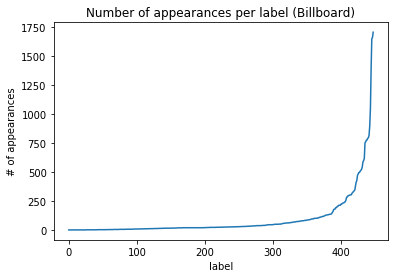

In [32]:
import matplotlib.pyplot as plt
scl_array = np.asarray(sorted_labels['count'])
scl_array.sort()
plt.title('Number of appearances per label (Billboard)')
plt.plot(scl_array)
plt.xlabel('label')
plt.ylabel('# of appearances')
plt.savefig('billboard.png')